In [2]:
from snn_delays.snn import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils import train, get_device, propagate_batch, to_plot, set_seed
from snn_delays.utils.test_behavior import tb_addtask
from snn_delays.utils.visualization_utils import plot_taus
device = get_device()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [3]:
time_window = 50
batch_size = 128 # 128: anil kag

ckpt_dir = 'sequential_tests_24_2_25'

dataset = 'addtask_episodic'
#dataset = 'addtask' 

DL = DatasetLoader(dataset=dataset, caching='', num_workers=0, batch_size=batch_size, total_time=time_window)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
#dataset_dict["time_ms"] = 2e3
dataset_dict["time_ms"] = 50

In [4]:
structure = (50, 2)

snn = SNN(dataset_dict, structure=structure, connection_type='f', delay=(50,1), delay_type='h',
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn.set_network()
snn.use_amp = False
snn.model_name = f'addask_d_50_50'
snn.input2spike_th = None
snn.num_train_samples = batch_size


[INFO] Delays: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

[INFO] Delays o: tensor([0])
50
Delta t: 1.0 ms
mean of normal: 2.9706281090573774


In [5]:
snn_mf = SNN(dataset_dict, structure=structure, connection_type='mf', delay=None, delay_type='',
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn_mf.multi_proj = 50

snn_mf.set_network()
snn_mf.use_amp = False
snn_mf.model_name = f'addask_d_50_50'
snn_mf.input2spike_th = None
snn_mf.num_train_samples = batch_size


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
50
Delta t: 1.0 ms
mean of normal: 2.9706281090573774


<Axes: xlabel='simulation timestep'>

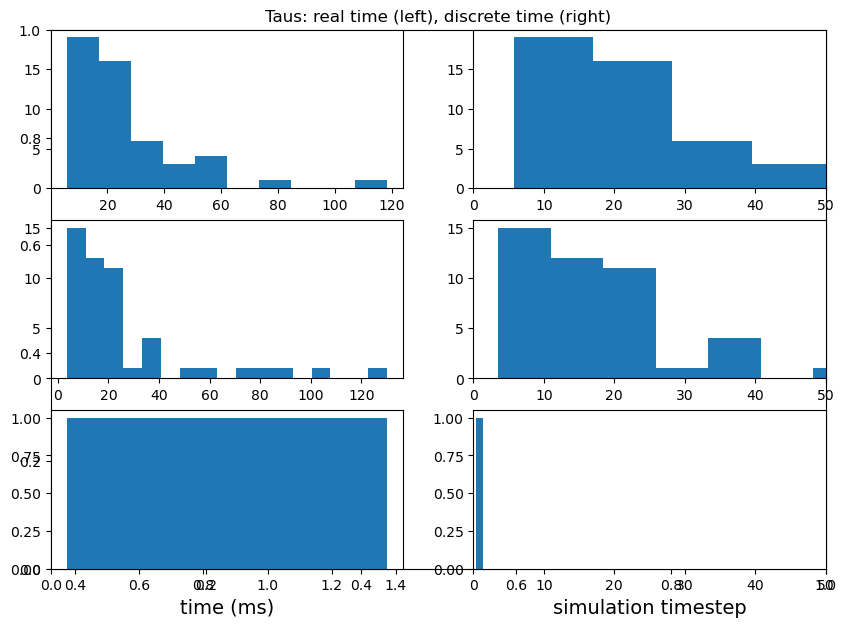

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plot_taus(snn)

<Axes: xlabel='simulation timestep'>

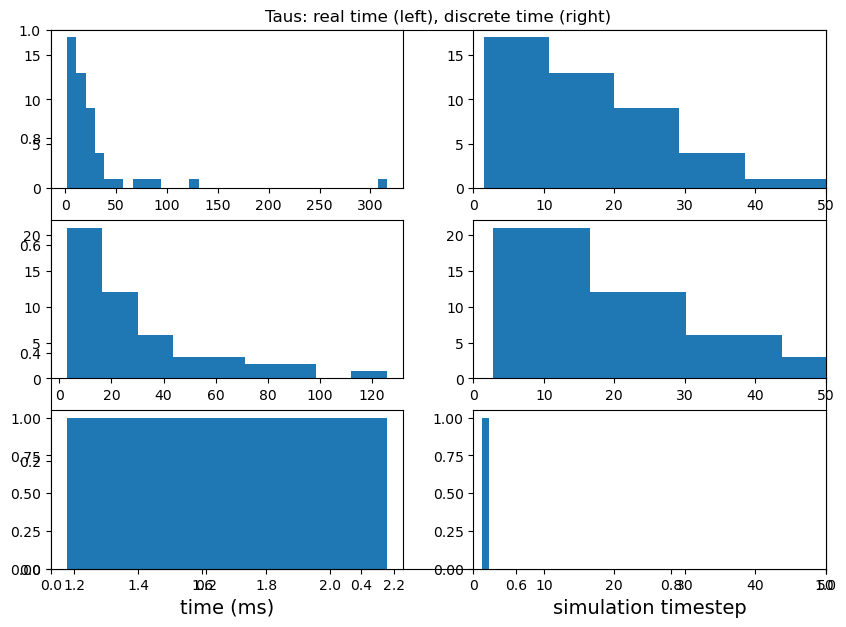

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plot_taus(snn_mf)

In [8]:
train(snn_mf, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), freeze_taus=True, clear=True)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\sequential_tests_24_2_25
Mean Error: 0.0014074579812586308% 
--------------------------


In [9]:
train(snn, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), freeze_taus=True, clear=True)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\sequential_tests_24_2_25
Mean Error: 0.0007639567484147847% 
--------------------------


Text(0.5, 1.0, 'train loss')

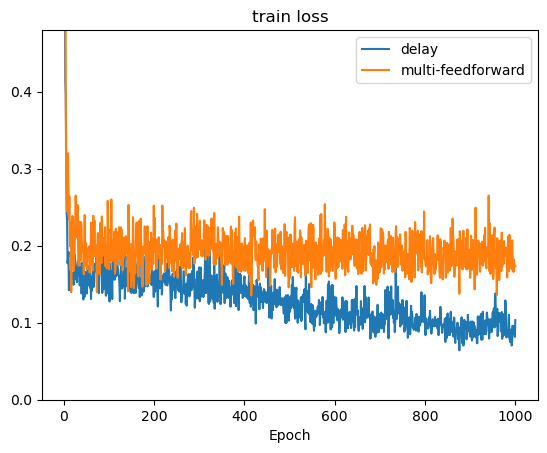

In [27]:
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
import numpy as np

loss_error = np.mean(np.array(snn.train_loss)[:,1][-100:])
plot_per_epoch(snn.train_loss, label = 'delay')
plot_per_epoch(snn_mf.train_loss, label = 'multi-feedforward')
#plt.title(f'loss error = {loss_error}')

plt.ylim(0, 5*loss_error)
plt.title('train loss')

<Axes: xlabel='simulation timestep'>

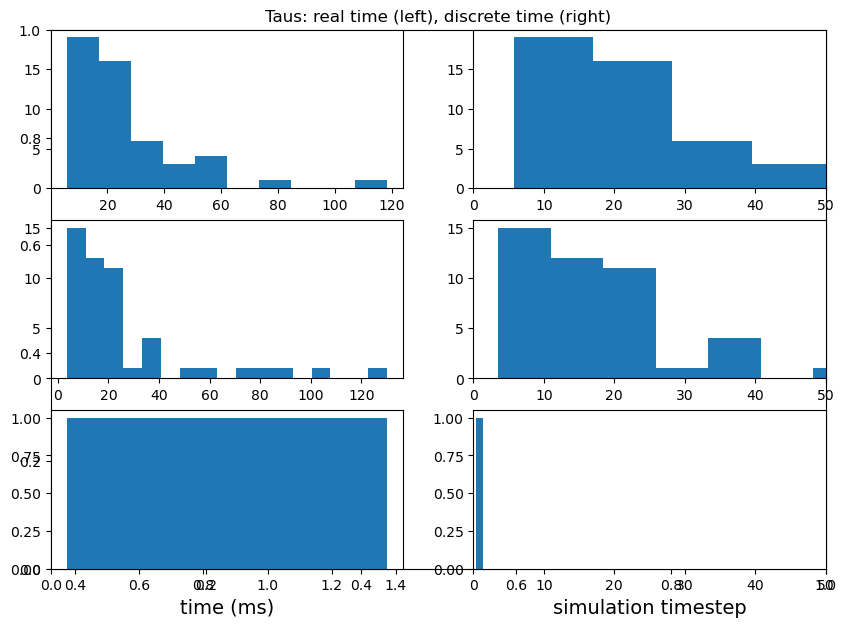

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plot_taus(snn)

<Axes: xlabel='simulation timestep'>

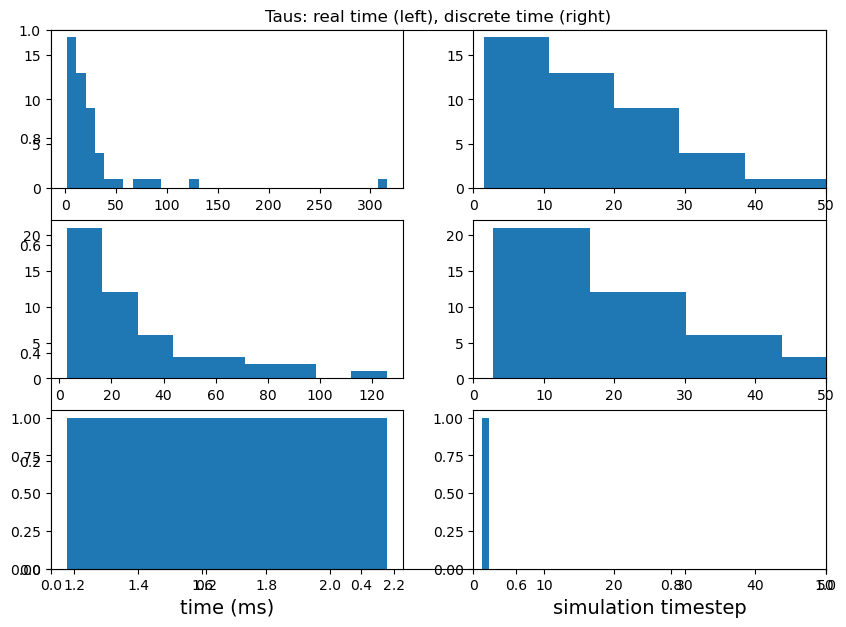

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plot_taus(snn_mf)

In [13]:
images, labels = propagate_batch(snn, test_loader)
_, labels_mf = propagate_batch(snn_mf, test_loader)

Text(0.5, 0, 'training sample')

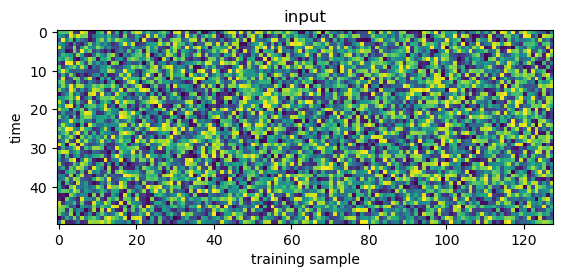

In [14]:
import matplotlib.pyplot as plt
plt.imshow(snn.spike_state['input'][:,:,0].cpu().numpy(), vmin=0, vmax=1)
plt.title('input')
plt.ylabel('time')
plt.xlabel('training sample')

Text(0.5, 0, 'training sample')

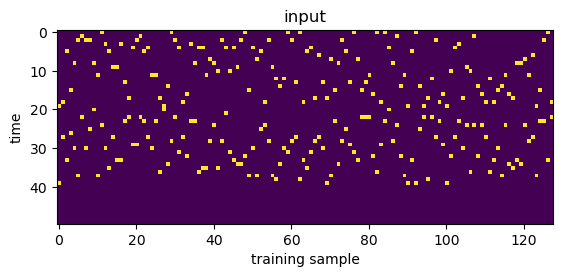

In [15]:
plt.imshow(snn.spike_state['input'][:,:,1].cpu().numpy(), vmin=0, vmax=1)
plt.title('input')
plt.ylabel('time')
plt.xlabel('training sample')

In [16]:
labels.shape

torch.Size([128, 10, 1])

0.2653982


Text(0.5, 0, 'training sample')

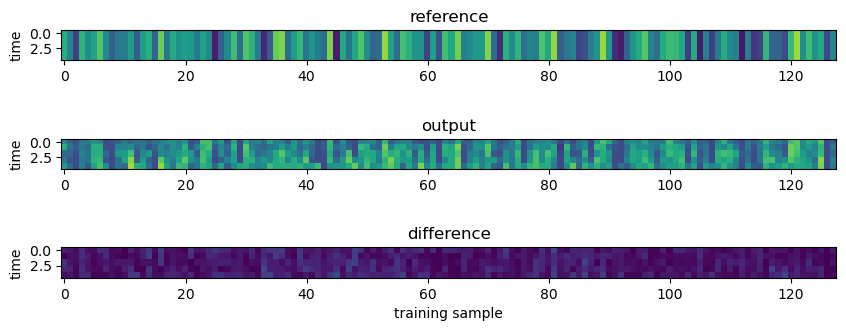

In [17]:
ref = labels[:,:5,0].T.cpu().numpy()
out = snn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()
diff = abs(ref-out[:,:,0])

import numpy as np
print(np.mean(diff))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(311)
plt.imshow(ref, vmin=0, vmax=2)
plt.title('reference')
plt.ylabel('time')

plt.subplot(312)
plt.imshow(out, vmin=0, vmax=2)
plt.title('output')
plt.ylabel('time')

plt.subplot(313)
plt.imshow(diff, vmin=0, vmax=4)
plt.title('difference')
plt.ylabel('time')
plt.xlabel('training sample')

0.2653982


Text(0.5, 0, 'training sample')

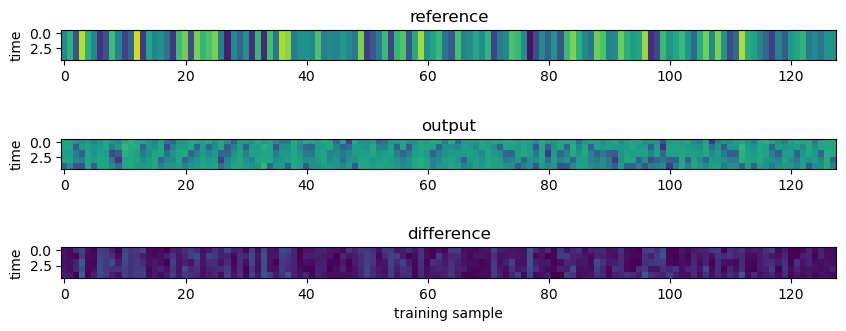

In [32]:
ref_mf = labels_mf[:,:5,0].T.cpu().numpy()
out_mf = snn_mf.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()
diff_mf = abs(ref_mf-out_mf[:,:,0])

import numpy as np
print(np.mean(diff))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(311)
plt.imshow(ref_mf, vmin=0, vmax=2)
plt.title('reference')
plt.ylabel('time')

plt.subplot(312)
plt.imshow(out_mf, vmin=0, vmax=2)
plt.title('output')
plt.ylabel('time')

plt.subplot(313)
plt.imshow(diff_mf, vmin=0, vmax=4)
plt.title('difference')
plt.ylabel('time')
plt.xlabel('training sample')

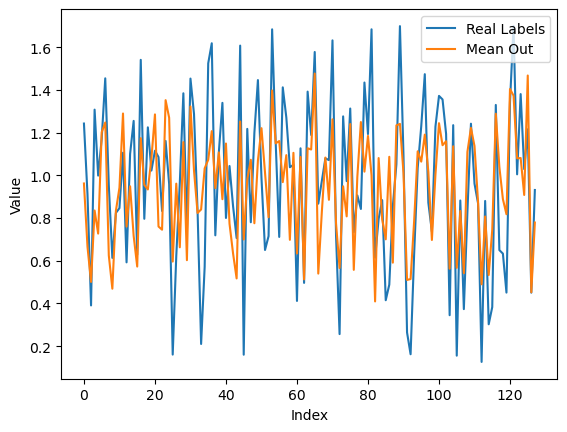

In [19]:
import numpy as np
#max_out = np.max(out, axis=0)
mean_out = np.mean(out, axis=0)

real_labels = labels[:, 0, 0]

import matplotlib.pyplot as plt
plt.plot(real_labels, label='Real Labels')
#plt.plot(max_out, label='Max Out')
plt.plot(mean_out, label='Mean Out')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

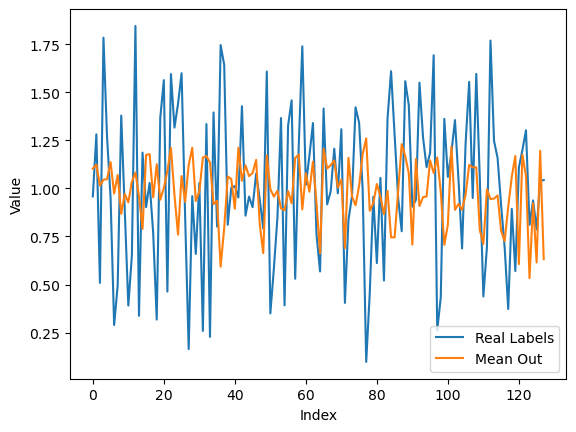

In [20]:
import numpy as np
#max_out = np.max(out, axis=0)
mean_out_mf = np.mean(out_mf, axis=0)

real_labels = labels_mf[:, 0, 0]

import matplotlib.pyplot as plt
plt.plot(real_labels, label='Real Labels')
#plt.plot(max_out, label='Max Out')
plt.plot(mean_out_mf, label='Mean Out')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

Text(0.5, 0, 'training sample')

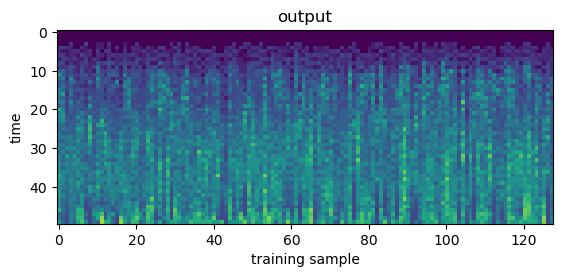

In [21]:
plt.imshow(snn.mem_state['output'].detach().cpu().numpy(), vmin=0, vmax=2)
plt.title('output')
plt.ylabel('time')
plt.xlabel('training sample')

Text(0.5, 0, 'training sample')

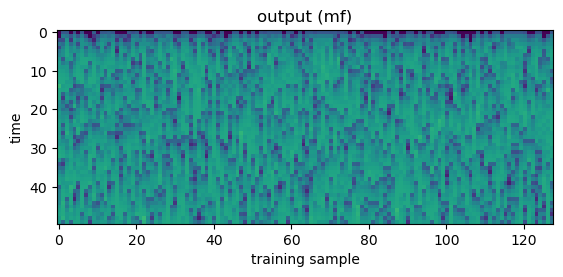

In [22]:
plt.imshow(snn_mf.mem_state['output'].detach().cpu().numpy(), vmin=0, vmax=2)
plt.title('output (mf)')
plt.ylabel('time')
plt.xlabel('training sample')

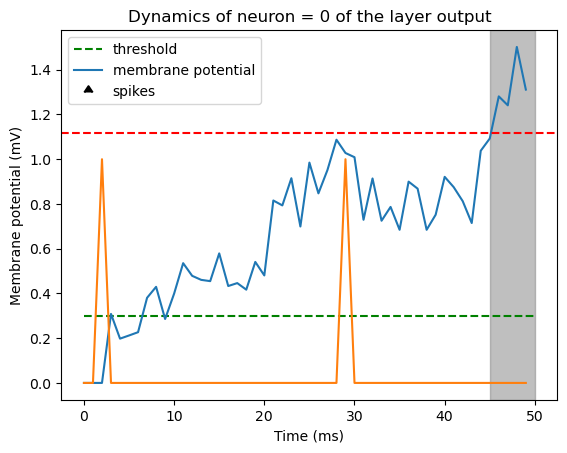

In [23]:
from snn_delays.utils.visualization_utils import visualize_activity
import numpy as np
import torch

N = np.random.randint(batch_size)
reference = torch.sum(snn.spike_state['input'][:,N,1]* snn.spike_state['input'][:,N,0]).item()

#print(snn.spike_state['input'][:,N,1])

#print(labels[N,:,0])
visualize_activity(snn, 'output', sample=N)
plt.plot(snn.spike_state['input'][:,N,1].cpu().numpy())
plt.axhline(y=reference, color='r', linestyle='--')
import matplotlib.pyplot as plt

plt.axvspan(0.9*time_window,time_window, color='gray', alpha=0.5)

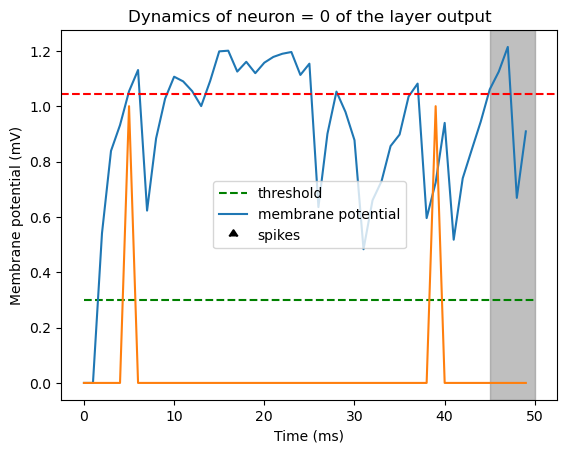

In [33]:
#N = np.random.randint(batch_size)
reference = torch.sum(snn_mf.spike_state['input'][:,N,1]* snn_mf.spike_state['input'][:,N,0]).item()

#print(snn.spike_state['input'][:,N,1])

#print(labels[N,:,0])
visualize_activity(snn_mf, 'output', sample=N)
plt.plot(snn.spike_state['input'][:,N,1].cpu().numpy())
plt.axhline(y=reference, color='r', linestyle='--')
import matplotlib.pyplot as plt

plt.axvspan(0.9*time_window,time_window, color='gray', alpha=0.5)

In [29]:
def get_errors_per_lapse(snn, num_trials):

    errors_per_lapse = [ [] for x in range(40)]

    for trial in range(num_trials):

        _, labels = propagate_batch(snn, test_loader)
        ref = labels[:,:5,0].T.cpu().numpy()
        out = snn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

        input_times = snn.spike_state['input'][:,:,1]

        outs = np.mean(out, axis=0)
        refs = np.mean(ref, axis=0)

        for sample in range(input_times.shape[1]):
            spike_times = torch.where(input_times[:, sample] == 1)[0]  # Get spike times
            dif = (spike_times[1] - spike_times[0]).item()
            errors_per_lapse[dif].append(abs(outs[sample]-refs[sample]))
    
    return errors_per_lapse

def plot_error_per_time(errors, label='Error per Time'):

    # Example nested list: times with corresponding errors
    # Replace this with your actual data
    times = range(40)

    # Calculate mean and standard deviation for each time point
    mean_errors = [np.mean(err) for err in errors]
    std_errors = [np.std(err) for err in errors]

    # Plotting
    #plt.figure(figsize=(10, 6))
    plt.errorbar(times, mean_errors, yerr=std_errors, fmt='o-', capsize=5, label=label)

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.title('Error per Time with Deviation')
    plt.legend()
    plt.grid(True)

    return plt.gca()

In [30]:

errors = get_errors_per_lapse(snn, 100)
errors_mf = get_errors_per_lapse(snn_mf, 100)

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: title={'center': 'Error per Time with Deviation'}, xlabel='Time', ylabel='Error'>

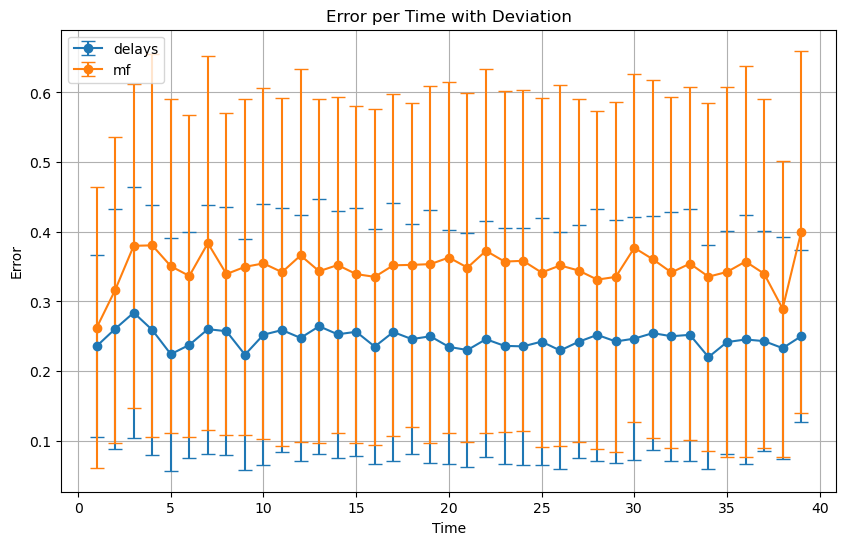

In [31]:
plt.figure(figsize=(10, 6))
plot_error_per_time(errors, 'delays')
plot_error_per_time(errors_mf, 'mf')

In [52]:
errors1 = get_errors_per_lapse(snn, 1)
errors_mf1 = get_errors_per_lapse(snn_mf, 1)

errors10 = get_errors_per_lapse(snn, 10)
errors_mf10 = get_errors_per_lapse(snn_mf, 10)

In [53]:
errors
sum(len(sublist) for sublist in errors)

128

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: title={'center': 'Error per Time with Deviation'}, xlabel='Time', ylabel='Error'>

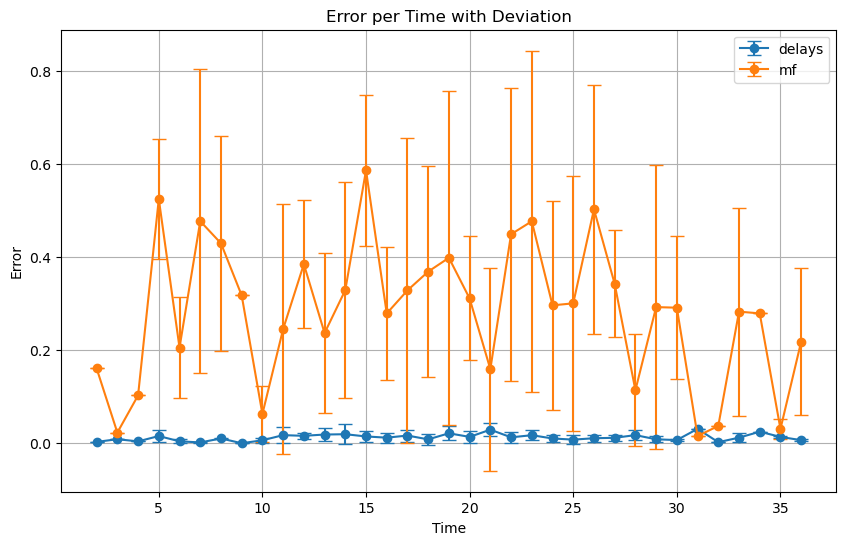

In [54]:
plt.figure(figsize=(10, 6))
plot_error_per_time(errors1, 'delays')
plot_error_per_time(errors_mf1, 'mf')

In [55]:
mean_errors = [np.mean(err) for err in errors1]
std_errors = [np.std(err) for err in errors1]
print(mean_errors)
print(std_errors)

[nan, nan, 0.0031591654, 0.008944273, 0.0042687654, 0.015738428, 0.0044420063, 0.0019899309, 0.010574423, 0.00030434132, 0.0066126585, 0.017694913, 0.016230546, 0.01898172, 0.019682951, 0.014884114, 0.012251213, 0.016808668, 0.008604209, 0.021643013, 0.013927251, 0.029451683, 0.012989378, 0.017535428, 0.010551674, 0.008044587, 0.011029263, 0.011952157, 0.017722894, 0.008754115, 0.0070877075, 0.031184196, 0.0025888681, 0.012293398, 0.025055647, 0.013924301, 0.00684613, nan, nan, nan]
[nan, nan, 0.0, 0.0, 0.0, 0.013732612, 0.0039492548, 0.0011165895, 0.0020426924, 0.0, 0.0059520006, 0.017275583, 0.006820991, 0.014499296, 0.020977046, 0.011267413, 0.010746129, 0.012854106, 0.012077997, 0.015351367, 0.012485811, 0.013736749, 0.011471034, 0.010293651, 0.008060586, 0.008969281, 0.007483492, 0.0069281436, 0.011305498, 0.0061998256, 0.0023045673, 0.0, 0.0, 0.009737909, 0.0, 0.00246948, 0.0024129748, nan, nan, nan]


In [56]:
errors1

[[],
 [],
 [array([0.00315917], dtype=float32)],
 [array([0.00894427], dtype=float32)],
 [array([0.00426877], dtype=float32)],
 [array([0.00200582], dtype=float32), array([0.02947104], dtype=float32)],
 [array([0.00049275], dtype=float32), array([0.00839126], dtype=float32)],
 [array([0.00204837], dtype=float32),
  array([0.00332731], dtype=float32),
  array([0.00059411], dtype=float32)],
 [array([0.01287961], dtype=float32),
  array([0.00784168], dtype=float32),
  array([0.01216972], dtype=float32),
  array([0.00940669], dtype=float32)],
 [array([0.00030434], dtype=float32)],
 [array([0.01256466], dtype=float32), array([0.00066066], dtype=float32)],
 [array([0.00140303], dtype=float32),
  array([0.02190077], dtype=float32),
  array([0.00327292], dtype=float32),
  array([0.04420292], dtype=float32)],
 [array([0.01850605], dtype=float32),
  array([0.00601947], dtype=float32),
  array([0.02495086], dtype=float32),
  array([0.0154458], dtype=float32)],
 [array([0.0153296], dtype=float32),

In [57]:
errors10

[[],
 [],
 [array([0.00315917], dtype=float32),
  array([0.00315917], dtype=float32),
  array([0.00315917], dtype=float32),
  array([0.00315917], dtype=float32),
  array([0.00315917], dtype=float32),
  array([0.00315917], dtype=float32),
  array([0.00315917], dtype=float32),
  array([0.00315917], dtype=float32),
  array([0.00315917], dtype=float32),
  array([0.00315917], dtype=float32)],
 [array([0.00894427], dtype=float32),
  array([0.00894427], dtype=float32),
  array([0.00894427], dtype=float32),
  array([0.00894427], dtype=float32),
  array([0.00894427], dtype=float32),
  array([0.00894427], dtype=float32),
  array([0.00894427], dtype=float32),
  array([0.00894427], dtype=float32),
  array([0.00894427], dtype=float32),
  array([0.00894427], dtype=float32)],
 [array([0.00426877], dtype=float32),
  array([0.00426877], dtype=float32),
  array([0.00426877], dtype=float32),
  array([0.00426877], dtype=float32),
  array([0.00426877], dtype=float32),
  array([0.00426877], dtype=float32),


<Axes: title={'center': 'Error per Time with Deviation'}, xlabel='Time', ylabel='Error'>

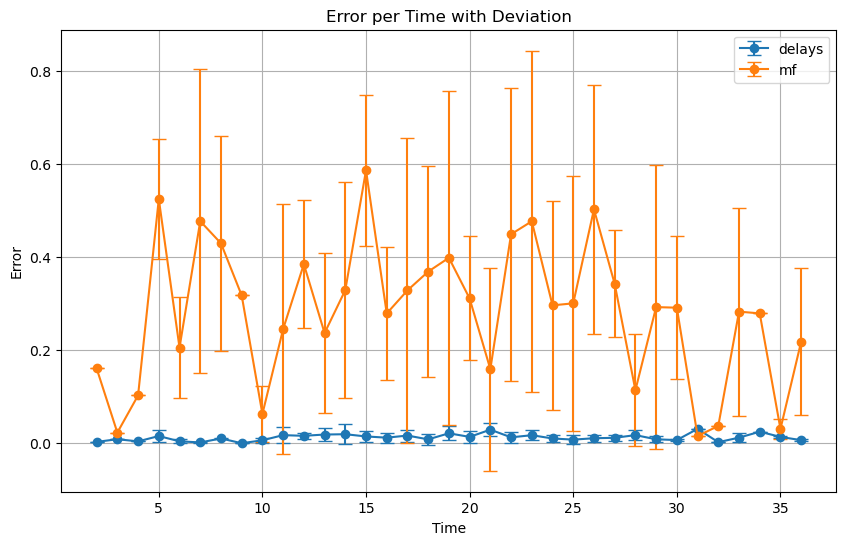

In [58]:
plt.figure(figsize=(10, 6))
plot_error_per_time(errors10, 'delays')
plot_error_per_time(errors_mf10, 'mf')

In [59]:
for x, y in train_loader:
    print(x)

tensor([[[0.1406, 0.0000],
         [0.5742, 0.0000],
         [0.7500, 0.0000],
         ...,
         [0.4219, 0.0000],
         [0.4141, 0.0000],
         [0.8477, 0.0000]],

        [[0.1523, 0.0000],
         [0.0781, 0.0000],
         [0.9688, 0.0000],
         ...,
         [0.5625, 0.0000],
         [0.2031, 0.0000],
         [0.2422, 0.0000]],

        [[0.7031, 1.0000],
         [0.9375, 0.0000],
         [0.4297, 0.0000],
         ...,
         [0.1289, 0.0000],
         [0.2031, 0.0000],
         [0.0703, 0.0000]],

        ...,

        [[0.2617, 0.0000],
         [0.9648, 0.0000],
         [0.6133, 1.0000],
         ...,
         [0.3945, 0.0000],
         [0.2500, 0.0000],
         [0.3516, 0.0000]],

        [[0.2148, 0.0000],
         [0.0547, 0.0000],
         [0.2578, 0.0000],
         ...,
         [0.4180, 0.0000],
         [0.7812, 0.0000],
         [0.0859, 0.0000]],

        [[0.9648, 0.0000],
         [0.0547, 0.0000],
         [0.7188, 0.0000],
         ...,
 